In [10]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import json
import functions

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [11]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(2*difference/summation)
    return error

In [12]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    
    return yhat[0]

Since now we can't use *ada_preprocessing()* to extract lagged values and concept, because it can potentially mess up breakpoint detection, we need separate function for this.

In [13]:
def manual_preprocessing(values):
    #receives the list of values up until and including the test point
    
    columns = ["t", "t-1", "t-2", "t-3", "t-4", "t-5"]
    
    #retrieve lagged values
    data = [values[-1], values[-2], values[-3], values[-4], values[-5], values[-6]]
    df = pd.DataFrame(columns=columns, data=[data])
    return df

In [14]:
#worst performing datasets from xgboost with retrain
list_of_names = ["nonlinear1_abrupt", "nonlinear1_inc"]

# list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
#                 "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
#                 "linear1_inc", "linear2_inc", "linear3_inc",
#                 "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 55.78m
SMAPE: 1.4177


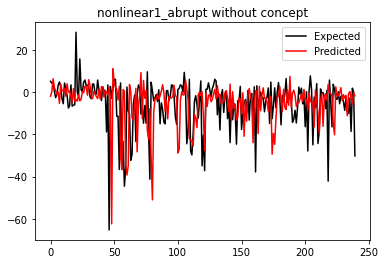

Time wasted: 51.14m
SMAPE: 1.4303


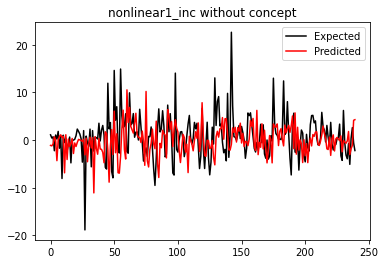

In [16]:
#dictionary to store the overall error
smape_dict = {}

#store the error for every step for both datasets
error1 = []
error2 = []

for name in list_of_names:
    start = time.perf_counter()
    
    #loading the data
    file_path = "data/"+name+"_series"
    data = pd.read_csv(file_path).iloc[:,0].to_list()
    
    #70/30 train/test split
    split = int(0.7*len(data))
    train, test = data[:split], data[split:]
    
    #get breakpoints for train set
    history = functions.ada_preprocessing(train)
    
    #note the last concept that appeared
    last_concept = history["concept"].iloc[-1]
    
    predictions = []
    ground_truth = []
    
    #negative value to prevent dropping part of the set if there is no breakpoint in first 20 values
    counter = -300
    
    for i in range(len(test)):
        #add new test observation to train series
        train.append(test[i])
        
        #pass all the values available in series up to and including the new test point
        test_df = manual_preprocessing(train)
        
        ground_truth.append(train[-1])
        
        #training data = history
        prediction = xgboost_forecast(history.loc[:,"t":"t-5"], test_df.loc[:,"t-1":"t-5"])
        predictions.append(prediction)
        
        #new dataframe with the predicted test observation already appended
        history = functions.ada_preprocessing(train)
        
        #note the real concept for the test observation
        new_concept = history["concept"].iloc[-1]
        
        #if the concept didn't change, keep increasing the counter
        if last_concept == new_concept:
            counter+=1
        #if the concept changed, actually start the counter
        #and switch the last seen concept
        else:
            last_concept = new_concept
            counter = 0
        
        #if we already have 20 points with new concept, drop part of the training data
        if counter == 20:
            history = history.tail(20)
#             print(history)
        
        #error at every step by daniel's request :D
        if name == "nonlinear1_abrupt":
            error1.append(smape(np.asarray(predictions), np.asarray(ground_truth)))
        else:
            error2.append(smape(np.asarray(predictions), np.asarray(ground_truth)))
            
    end = time.perf_counter()
    print("Time wasted: {:.2f}m".format((end-start)/60))
    
    error = smape(np.asarray(predictions), np.asarray(ground_truth))
    smape_dict[name] = error
    print("SMAPE: {:.4f}".format(error))
    plt.plot(ground_truth, label = "Expected", color = "black")
    plt.plot(predictions, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} without concept".format(name))    
    plt.show()

In [17]:
error1

[2.0,
 1.9366092656178981,
 1.3919354626300242,
 1.4281710752719148,
 1.5425368602175318,
 1.305621525950251,
 1.4048184508145007,
 1.4792161444626883,
 1.3543827816107592,
 1.4189445034496833,
 1.4717677304088033,
 1.4162950967437078,
 1.4611954739172686,
 1.4996815114946067,
 1.5316339174664046,
 1.5609067976247544,
 1.5867358095291806,
 1.5175410656624797,
 1.542933641153928,
 1.4805398088385855,
 1.5052760084177006,
 1.5277634625805325,
 1.4802084196899725,
 1.50186640220289,
 1.5217917461147743,
 1.467043203049852,
 1.486782343677635,
 1.4586906595092195,
 1.4179952623932852,
 1.437395420313509,
 1.4212943142635424,
 1.439378866942807,
 1.4053134882513454,
 1.4228042680086588,
 1.431769189637255,
 1.3948837014699964,
 1.3798987681987434,
 1.3962172216671975,
 1.3661382769358323,
 1.3819848200124367,
 1.3970583609877432,
 1.366888681587446,
 1.381612200620296,
 1.3935345296313943,
 1.4052031320751093,
 1.4181334987691285,
 1.4305136370931897,
 1.4423779363204148,
 1.450092403227319

In [18]:
error2

[2.0,
 2.0,
 2.0,
 2.0,
 1.9938389435871482,
 1.9948657863226236,
 1.985775423097148,
 1.9875534952100045,
 1.797392707280655,
 1.8176534365525896,
 1.678012554642483,
 1.6810096675471125,
 1.623034112585954,
 1.5472161166331395,
 1.577401708857597,
 1.603814102053997,
 1.5967337599638518,
 1.6038227416858233,
 1.622419915634897,
 1.641298919853152,
 1.6583799236696686,
 1.6739081089574108,
 1.675767432285624,
 1.687471929316068,
 1.6999730521434253,
 1.7020333883910412,
 1.7019481500805482,
 1.692379924769617,
 1.6597126896516319,
 1.6549269942465132,
 1.6148376004013698,
 1.6007933732852941,
 1.5850818801179474,
 1.5734808929169202,
 1.5658614792092282,
 1.5257083179752484,
 1.5385270120840253,
 1.5506710380818143,
 1.55395808517038,
 1.5554942022840483,
 1.5663358071063889,
 1.5766611450324273,
 1.5865062346828358,
 1.5959038202582259,
 1.6048837353635987,
 1.6134732193774335,
 1.6216971934332327,
 1.6295785019033737,
 1.637138124313509,
 1.6222380997901382,
 1.6066353096063601,
 1.